<a href="https://colab.research.google.com/github/RanelDL/TensorFlowCourse/blob/main/C2/W3/Assignment/transfer_learning_horse_vs_human.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Week 3: Transfer Learning
Welcome to this assignment! This week, you are going to use a technique called Transfer Learning in which you utilize an already trained network to help you solve a similar problem to the one it was originally trained to solve.

In [1]:
# Imports
import zipfile
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import RMSprop

Dataset
For this assignment, you will use the Horse or Human dataset, which contains images of horses and humans.

Download the training and validation sets by running the cell below:

In [2]:
# Get the Horse or Human training dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
# -P /content/ sets the directory prefix to /content/ instead of . (cur dir)
# -q quiet wget(no output)

# Get the Horse or Human validation dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

test_local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r') #instantiate the ZipFile class - making a zipfile object by opening the downloaded zip in 'reading' mode
zip_ref.extractall('/tmp/training')

val_local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(val_local_zip, 'r')
zip_ref.extractall('/tmp/validation')

zip_ref.close()

This dataset already has an structure that is compatible with Keras' flow_from_directory so you don't need to move the images into subdirectories as you did in the previous assignments. However, it is still a good idea to save the paths of the images so you can use them later on:

In [3]:
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Existing paths
horse_train_dir = os.path.join(train_dir, 'horses')
horse_val_dir = os.path.join(validation_dir, 'horses')

human_train_dir = os.path.join(train_dir, 'humans')
human_val_dir = os.path.join(validation_dir, 'humans')

Now take a look at a sample image of each one of the classes:

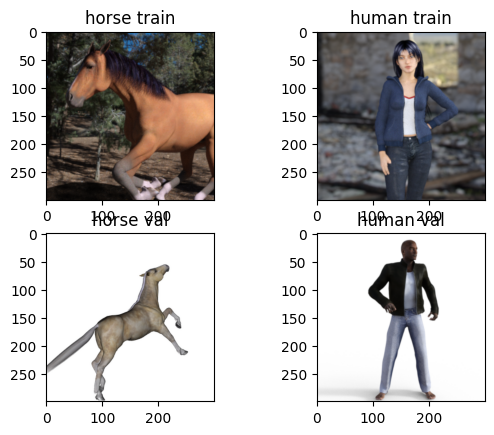

In [4]:
fig, ax = plt.subplots(2,2)
ax[0][0].set_title('horse train')
ax[1][0].set_title('horse val')
ax[0][1].set_title('human train')
ax[1][1].set_title('human val')

ax[0][0].imshow(load_img(os.path.join(horse_train_dir, os.listdir(horse_train_dir)[0]) ))
ax[1][0].imshow(load_img(os.path.join(horse_val_dir, os.listdir(horse_val_dir)[0]) ))
ax[0][1].imshow(load_img(os.path.join(human_train_dir, os.listdir(human_train_dir)[0]) ))
ax[1][1].imshow(load_img(os.path.join(human_val_dir, os.listdir(human_val_dir)[0]) ))

matplotlib makes it easy to see that these images have a resolution of 300x300 and are colored, but you can double check this by using the code below:



In [5]:
sample_img = load_img(os.path.join(human_val_dir, os.listdir(human_val_dir)[0]) )
sample_img = img_to_array(sample_img)
print(sample_img.shape)

(300, 300, 3)


Training and Validation Generators
Now that you know the images you are dealing with, it is time for you to code the generators that will fed these images to your Network. For this, complete the train_val_generators function below:

Important Note: The images have a resolution of 300x300 but the flow_from_directory method you will use allows you to set a target resolution. In this case, set a target_size of (150, 150). This will heavily lower the number of trainable parameters in your final network, yielding much quicker training times without compromising the accuracy!

In [6]:
def train_val_generators(TRAIN_DIR, VAL_DIR):
    """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator: tuple containing the generators
  """
    # instantiate ImDG class
    train_gen_obj = ImageDataGenerator(rescale = 1./255,
    rotation_range = 40,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    fill_mode='nearest')
    # get generator from ImDG object method
    train_gen = train_gen_obj.flow_from_directory(directory = TRAIN_DIR,
    target_size = (150,150),
    batch_size = 32, class_mode = 'binary')

    val_gen_obj = ImageDataGenerator(rescale = 1./255)
    val_gen = val_gen_obj.flow_from_directory(directory = VAL_DIR,
    target_size = (150,150),
    batch_size = 32, class_mode = 'binary')
    return train_gen, val_gen

In [7]:
train_generator, val_generator = train_val_generators(train_dir, validation_dir)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


Download the inception V3 weights into the /tmp/ directory:



In [8]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-03-09 14:29:13--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.207, 74.125.203.207, 64.233.187.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  24.0MB/s    in 4.1s    

2024-03-09 14:29:18 (20.5 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [9]:
WEIGHTS = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


Complete the create_pre_trained_model function below. You should specify the correct input_shape for the model (remember that you set a new resolution for the images instead of the native 300x300) and make all of the layers non-trainable:

In [10]:
def create_pretrained_model(local_weights_file):
  model = InceptionV3(include_top = False, weights = local_weights_file, input_shape = (150,150,3))
  # alternatively, run model.load_weights(wfile)
  for layer in model.layers:
    layer.trainable = False # Freeze layers
  return model

In [11]:
Inception = create_pretrained_model(WEIGHTS)

Check that everything went well by comparing the last few rows of the model summary to the expected output:



In [12]:
Inception.summary() # in the end we see the number of trainable parameters
# it's supposed to be 0 ( since we made all layers untrainable)

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

Creating callbacks for later
You have already worked with callbacks in the first course of this specialization so the callback to stop training once an accuracy of 99.9% is reached, is provided for you:

In [13]:
class MyCallback(Callback):
  def on_epoch_end(self,epoch,logs={}):
    if logs.get('accuracy') >= 0.999:
      print("Reached 99.9% acc, stopping..\n")
      self.model.stop_training = True # when the class is instantiated,
      # the model is passed via the constructor to self.model

Pipelining the pre-trained model with your own
Now that the pre-trained model is ready, you need to "glue" it to your own model to solve the task at hand.

For this you will need the last output of the pre-trained model, since this will be the input for your own. Complete the output_of_last_layer function below.

Note: For grading purposes use the mixed7 layer as the last layer of the pre-trained model. However, after submitting feel free to come back here and play around with this.

In [14]:
def output_of_last_layer(pre_trained_model):
  """
  Gets the last layer output of a model

  Args:
    pre_trained_model (tf.keras Model): model to get the last layer output from

  Returns:
    last_output: output of the model's last layer
  """
  #last_layer = Inception.layers attribute of object- an array of layers
  last_layer = pre_trained_model.get_layer('mixed7')# method to get specific layer by name or index
  last_output = last_layer.output
  print('last layer output shape: ', last_layer.output_shape)
  print('last layer output: ', last_output)
  return last_output

In [15]:

last_output = output_of_last_layer(Inception)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


Now you will create the final model by adding some additional layers on top of the pre-trained model.

Complete the create_final_model function below. You will need to use Tensorflow's Functional API for this since the pretrained model has been created using it.

Let's double check this first:

In [16]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(Inception)}")

The pretrained model has type: <class 'keras.src.engine.functional.Functional'>


To create the final model, you will use Keras' Model class by defining the appropriate inputs and outputs as described in the first way to instantiate a Model in the docs.

Note that you can get the input from any existing model by using its input attribute and by using the Funcional API you can use the last layer directly as output when creating the final model.

In [17]:
import numpy as np
import tensorflow as tf
from keras import layers
import keras


In [18]:
def create_final_model(pre_trained_model, last_output):
  """
  Appends a custom model to a pre-trained model

  Args:
    pre_trained_model (tf.keras Model): model that will accept the train/test inputs
    last_output (tensor): last layer output of the pre-trained model

  Returns:
    model: the combined model
  """

  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  # same as x= layers.flatten()
  #         x = x(last_output)

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(1024, activation = 'relu') (x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2) (x)

  # Add a final sigmoid layer for classification
  x = layers.Dense(1,activation="sigmoid")(x)

  # Create the complete model by using the Model class. || x is basically last layer
  model = keras.Model(inputs = pre_trained_model.inputs, outputs = x, name = 'modified_model')# keras.Model == Model since we imported keras
  # inputs arg expects tensorflow inputs object (Every tensorflow model has an inputs attribute)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  ### END CODE HERE

  return model

In [19]:
# Save your model in a variable
model = create_final_model(Inception, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


After submitting your assignment later, try re-running this notebook but use the original resolution of 300x300, you will be surprised to see how many more parameters are for that case.

Now train the model:

In [20]:
call = MyCallback() #instantiate the callback class
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = 100,
                    verbose = 1,
                    callbacks = call)

Epoch 1/100
33/33 [==============================] - 78s 2s/step - loss: 0.1888 - accuracy: 0.9387 - val_loss: 0.0449 - val_accuracy: 0.9844
Epoch 2/100
33/33 [==============================] - 73s 2s/step - loss: 0.0377 - accuracy: 0.9883 - val_loss: 0.0147 - val_accuracy: 0.9922
Epoch 3/100
33/33 [==============================] - 90s 3s/step - loss: 0.0285 - accuracy: 0.9912 - val_loss: 0.0047 - val_accuracy: 0.9961
Epoch 4/100
33/33 [==============================] - 90s 3s/step - loss: 0.0116 - accuracy: 0.9942 - val_loss: 0.0252 - val_accuracy: 0.9883
Epoch 5/100
33/33 [==============================] - 73s 2s/step - loss: 0.0122 - accuracy: 0.9961 - val_loss: 0.0116 - val_accuracy: 0.9961
Epoch 6/100
33/33 [==============================] - 73s 2s/step - loss: 0.0192 - accuracy: 0.9922 - val_loss: 0.0327 - val_accuracy: 0.9883
Epoch 7/100
33/33 [==============================] - 73s 2s/step - loss: 0.0109 - accuracy: 0.9971 - val_loss: 0.0207 - val_accuracy: 0.9883
Epoch 8/100
3

The training should have stopped after less than 10 epochs and it should have reached an accuracy over 99,9% (firing the callback). This happened so quickly because of the pre-trained model you used, which already contained information to classify humans from horses. Really cool!

Now take a quick look at the training and validation accuracies for each epoch of training:

In [21]:
print(history.history.keys())# History object with history attribute which is a dictionary of metrics

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


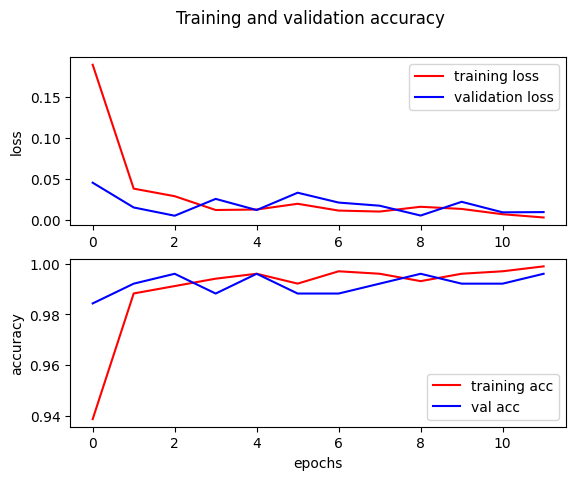

In [38]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(len(train_loss))
fig, (ax1, ax2) = plt.subplots(2,1)
fig.suptitle('Training and validation accuracy')
ax1.plot(epochs, train_loss, color = 'r', label = 'training loss')
ax1.plot(epochs, val_loss, color = 'b', label = 'validation loss')
ax1.set_ylabel("loss")
ax2.plot(epochs, train_acc, color = 'r', label = 'training acc')
ax2.plot(epochs, val_acc, color = 'b', label = 'val acc')
ax2.set_ylabel("accuracy")
ax2.set_xlabel("epochs")

'''
#.plot( epochs, train_loss, color = 'r', label = 'training loss')
#plt.plot(epochs, val_loss, color = 'b', label = 'validation loss')

plt.plot(epochs, train_acc, color = 'r', label = 'training acc')
plt.plot(epochs, val_acc, color = 'b', label = 'val acc')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
'''
ax1.legend() # lets us know which color is which graph
ax2.legend()
plt.show() # what does it show? how do the previous axes relate to this method?